### Record

This version is used for comparing the tradeoff

----
Process
1. Data preparation
   * \# of rows: 131097, # of clicks: 6091
   * choose gender as sensitive attribute 
   * \# of rows: 131097 -> 88652
 
2. Choose baseline model
    * logitsic regression predicting all the obs to 0
        * tpr and fpr are 0 when c changes from 0.01 to 10000
    * label predictions of cart changes as ccp_alpha changes
        * use default threshold
        * choose ccp_alpha in terms of tpr and fpr
3. Evaluate fairness in the baseline model using testing data
4. Incorparate fairness constraint
    * default
    * a list of difference_bound
    * a list of ratio_bound
5. Tradeoff 
    * percentage change of tpr and fpr
----

Question

1. What metrics to use for choosing hyperparameters in cart and random forest?
2.  Can we implement logistic regression in fairlearn?


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from fairlearn.metrics import MetricFrame
# from sklearn.metrics import log_loss

## Fairlearn package

#### Example

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
data = fetch_openml(data_id=1590, as_frame=True)
X = pd.get_dummies(data.data)
y_true = (data.target == '>50K') * 1
sex = data.data['sex']

In [ ]:
sex.value_counts()

In [ ]:
32650 + 16192

In [ ]:
X.shape

#### evaluating fairness

In [ ]:
classifier_test = DecisionTreeClassifier(min_samples_leaf=10, max_depth=4)
classifier_test.fit(X, y_true)
y_pred = classifier_test.predict(X)
gm = MetricFrame(accuracy_score, y_true, y_pred, sensitive_features=sex)
print(gm.overall)

In [ ]:
print(gm.by_group)

In [ ]:
sex

In [ ]:
X[['sex_Female','sex_Male']].head()

### Evaluating fairness

In [32]:
X1_test.columns

Index(['Timestamp_impressions', 'Region ID_impressions', 'Ad Exchange',
       'Ad Slot Width', 'Ad Slot Height', 'Ad Slot Visibility',
       'Ad Slot Format', 'Ad Slot Floor Price', 'Bidding Price',
       'Paying Price', 'Advertiser ID', '10006', '10024', '10031', '10048',
       '10052', '10057', '10059', '10063', '10067', '10074', '10075', '10076',
       '10077', '10079', '10083', '10093', '10102', 'is_male', '10684',
       '11092', '11278', '11379', '11423', '11512', '11576', '11632', '11680',
       '11724', '11944', '13042', '13403', '13496', '13678', '13776', '13800',
       '13866', '13874', '14273', '16593', '16617', '16661', '16706'],
      dtype='object')

In [56]:
# Sensitive attribute 10110
gender = X1_test['is_male']

## Metigating disparity 

#### CART

In [34]:
classifier_dtc = DecisionTreeClassifier(ccp_alpha=0.01, min_samples_leaf=5, min_samples_split=20, max_depth=30, random_state=88)

In [35]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
import time 

tic = time.time()

np.random.seed(0)
constraint = DemographicParity()
mitigator_dtc = ExponentiatedGradient(classifier_dtc, constraint)
mitigator_dtc.fit(X1_test_enc, y1_test_enc, sensitive_features=gender)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

time: 18.61 s


In [36]:
y1_pred_dtc_mitigated = mitigator_rf.predict(X1_test_enc)

In [37]:
from sklearn.metrics import confusion_matrix

def tpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tpr = cm.ravel()[3] / (cm.ravel()[2] + cm.ravel()[3])
    return tpr

def fpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fpr = cm.ravel()[1] / (cm.ravel()[0] + cm.ravel()[1])
    return fpr

#### TPR

In [40]:
tpr_dtc_mitigated = MetricFrame(tpr, y1_test_enc, y1_pred_dtc_mitigated, sensitive_features=gender)

In [41]:
print(tpr_dtc_mitigated.overall)

0.557711950970378


In [42]:
print(tpr_dtc_mitigated.by_group)

is_male
0.0    0.538012
1.0    0.572983
Name: tpr, dtype: object


#### FPR

In [45]:
fpr_dtc_mitigated = MetricFrame(fpr, y1_test_enc, y1_pred_dtc_mitigated, sensitive_features=gender)
print('Mitigated fpr of CART is: ', fpr_dtc_mitigated.overall)
print('Mitigated fpr of CART by group is:\n', fpr_dtc_mitigated.by_group)

Mitigated fpr of CART is:  0.0030599196200219217
Mitigated fpr of CART by group is:
 is_male
0.0    0.003241
1.0    0.002968
Name: fpr, dtype: object


#### Comparison with baseline

In [53]:
# percentage decrease of TPR
(tpr_dtc - tpr_dtc_mitigated.overall)/tpr_dtc

0.13057324840764334

In [55]:
# percentage decrease of FPR
(fpr_dtc - fpr_dtc_mitigated.overall) / fpr_dtc

0.06944444444444449

#### Tradeoff

In [84]:
# a list of difference_bound
bound_list = list(np.linspace(0, 0.05, 50))
# relative change of tpr
tpr_dtc_list = [np.nan]*len(bound_list)
# relative change of fpr
fpr_dtc_list = [np.nan]*len(bound_list)

In [85]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.metrics import confusion_matrix
import time


def tpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tpr = cm.ravel()[3] / (cm.ravel()[2] + cm.ravel()[3])
    return tpr

def fpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fpr = cm.ravel()[1] / (cm.ravel()[0] + cm.ravel()[1])
    return fpr

# baseline
classifier_dtc = DecisionTreeClassifier(ccp_alpha=0.01, min_samples_leaf=5, 
                                            min_samples_split=20, max_depth=30, random_state=88)

tic = time.time()

for i in range(len(bound_list)):
    sample_i = bound_list[i]
    # mitigating disparity
    np.random.seed(0)
    constraint = DemographicParity(difference_bound=sample_i)
    mitigator_dtc = ExponentiatedGradient(classifier_dtc, constraint)
    mitigator_dtc.fit(X1_train_enc, y1_train_enc, sensitive_features=gender)
    y1_pred_dtc = mitigator_dtc.predict(X1_test_enc)
    
    # evaluating fairness in terms of tpr
    tpr_dtc_mitigated_i = MetricFrame(tpr, y1_test_enc, y1_pred_dtc, sensitive_features=gender)
    relative_change_tpr_i = (tpr_dtc - tpr_dtc_mitigated_i.overall) / tpr_dtc
    tpr_dtc_list[i] = relative_change_tpr_i
    
    #evaluating fairness in terms of fpr
    fpr_dtc_mitigated_i = MetricFrame(fpr, y1_test_enc, y1_pred_dtc, sensitive_features=gender)
    relative_change_fpr_i = (fpr_dtc - fpr_dtc_mitigated_i.overall) / fpr_dtc
    fpr_dtc_list[i] = relative_change_fpr_i
    
toc = time.time()

print('time:', round(toc-tic,2), 's')

In [87]:
tpr_dtc_list
# tpr_dtc_list_r = list(reversed(tpr_dtc_list))

[0.24681528662420385,
 0.23566878980891723,
 0.22213375796178345,
 0.20302547770700638,
 0.19187898089171976,
 0.18232484076433125,
 0.17197452229299376,
 0.16321656050955427,
 0.15047770700636948,
 0.14251592356687895,
 0.12738853503184724,
 0.12181528662420382,
 0.10907643312101922,
 0.10191082802547768,
 0.08757961783439494,
 0.07563694267515932,
 0.0732484076433122,
 0.05971337579617844,
 0.051751592356687914,
 0.042197452229299416,
 0.0302547770700638,
 0.017515923566879022,
 0.0015923566878981402,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [88]:
fpr_dtc_list
# fpr_dtc_list_r = list(reversed(fpr_dtc_list))

In [91]:
comparison_dtc = pd.DataFrame({'difference_bound':bound_list, 
                               'decrease%_TPR': tpr_dtc_list, 'decrease%_FPR': fpr_dtc_list})

In [93]:
comparison_dtc.head(10)

,difference_bound,decrease%_TPR,decrease%_FPR
0,0.000000,0.246815,0.152778
1,0.001020,0.235669,0.152778
2,0.002041,0.222134,0.152778
3,0.003061,0.203025,0.152778
4,0.004082,0.191879,0.152778
5,0.005102,0.182325,0.125000
6,0.006122,0.171975,0.125000
7,0.007143,0.163217,0.097222
8,0.008163,0.150478,0.097222
9,0.009184,0.142516,0.083333


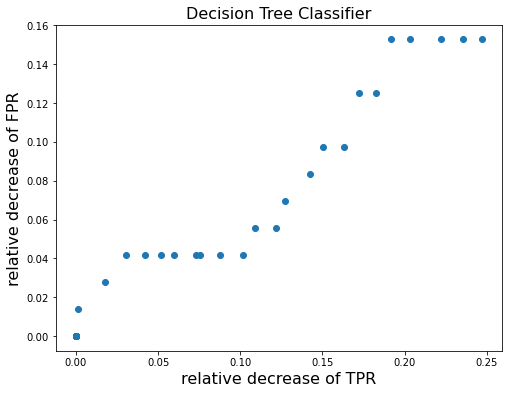

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.title('Decision Tree Classifier', fontsize=16)
plt.xlabel('relative decrease of TPR', fontsize=16)
plt.ylabel('relative decrease of FPR', fontsize=16)
plt.scatter(x=tpr_dtc_list, y=fpr_dtc_list)

* Conslusion: 
1. percentage change decreases as difference_bound gets looser
2. TPR is more sensitive to the change of difference_bound

#### Random forest

In [94]:
classifier_rf = RandomForestClassifier(max_features=16, min_samples_leaf=5, max_depth=30, n_estimators=500, random_state=88)

In [100]:
classifier_rf.fit(X1_train_enc, y1_train_enc)
y1_pred_rf = classifier_rf.predict(X1_test_enc)

<ipython-input-100-4e4fb603f47f>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  classifier_rf.fit(X1_train_enc, y1_train_enc)


In [101]:
tpr_rf = tpr(y1_test_enc, y1_pred_rf)
fpr_rf = fpr(y1_test_enc, y1_pred_rf)

In [95]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
import time 

tic = time.time()

np.random.seed(0)
constraint = DemographicParity()
mitigator_rf = ExponentiatedGradient(classifier_rf, constraint)
mitigator_rf.fit(X1_test_enc, y1_test_enc, sensitive_features=gender)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

time: 990.31 s


In [96]:
y1_pred_rf_mitigated = mitigator_rf.predict(X1_test_enc)

In [97]:
# TPR
tpr_rf_mitigated = MetricFrame(tpr, y1_test_enc, y1_pred_rf_mitigated, sensitive_features=gender)
print(tpr_rf_mitigated.overall)
print(tpr_rf_mitigated.by_group)

0.719611848825332
is_male
0.0    0.694737
1.0    0.738894
Name: tpr, dtype: object


In [102]:
# percentage decrease in tpr
(tpr_rf - tpr_rf_mitigated.overall)/tpr_rf

-0.00786838340486411

In [98]:
# FPR
fpr_rf_mitigated = MetricFrame(fpr, y1_test_enc, y1_pred_rf_mitigated, sensitive_features=gender)
print(fpr_rf_mitigated.overall)
print(fpr_rf_mitigated.by_group)

0.00401899890390939
is_male
0.0    0.000405
1.0    0.005866
Name: fpr, dtype: object


In [103]:
# percentage decrease in fpr
(fpr_rf - fpr_rf_mitigated.overall)/fpr_rf

-0.8723404255319149

#### difference_bound

In [104]:
# # a list of difference_bound
# bound_list = list(np.linspace(0, 0.05, 50))
# relative change of tpr
tpr_rf_list = [np.nan]*len(bound_list)
# relative change of fpr
fpr_rf_list = [np.nan]*len(bound_list)

In [105]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.metrics import confusion_matrix
import time


def tpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tpr = cm.ravel()[3] / (cm.ravel()[2] + cm.ravel()[3])
    return tpr

def fpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fpr = cm.ravel()[1] / (cm.ravel()[0] + cm.ravel()[1])
    return fpr

# baseline
classifier_rf = RandomForestClassifier(max_features=16, min_samples_leaf=5, 
                                       max_depth=30, n_estimators=500, random_state=88)

tic = time.time()

for i in range(len(bound_list)):
    sample_i = bound_list[i]
    # mitigating disparity
    np.random.seed(0)
    constraint = DemographicParity(difference_bound=sample_i)
    mitigator_rf = ExponentiatedGradient(classifier_rf, constraint)
    mitigator_rf.fit(X1_train_enc, y1_train_enc, sensitive_features=gender)
    y1_pred_rf = mitigator_rf.predict(X1_test_enc)
    
    # evaluating fairness in terms of tpr
    tpr_rf_mitigated_i = MetricFrame(tpr, y1_test_enc, y1_pred_rf, sensitive_features=gender)
    relative_change_tpr_i = (tpr_rf - tpr_rf_mitigated_i.overall) / tpr_rf
    tpr_rf_list[i] = relative_change_tpr_i
    
    #evaluating fairness in terms of fpr
    fpr_rf_mitigated_i = MetricFrame(fpr, y1_test_enc, y1_pred_rf, sensitive_features=gender)
    relative_change_fpr_i = (fpr_rf - fpr_rf_mitigated_i.overall) / fpr_rf
    fpr_rf_list[i] = relative_change_fpr_i
    
toc = time.time()

print('time:', round(toc-tic,2), 's')

/opt/anaconda3/lib/python3.8/site-packages/fairlearn/reductions/_exponentiated_gradient/_lagrangian.py:139: OptimizeWarning: The pivot operation produces a pivot value of: 4.7e-06, which is only slightly greater than the specified tolerance 1.0e-09. This may lead to issues regarding the numerical stability of the simplex method. Removing redundant constraints, changing the pivot strategy via Bland's rule or increasing the tolerance may help reduce the issue.
  result_dual = opt.linprog(dual_c,


KeyboardInterrupt: 

## Data preparation

In [2]:
com_ad = pd.read_csv('imp_to_click_final.csv')
com_ad.drop(['Unnamed: 0'], axis=1, inplace=True)
# com_ad.info()
com_ad.head()

,Timestamp_impressions,Log Type,User-Agent_impressions,Region ID_impressions,City ID,Ad Exchange,Ad Slot Width,Ad Slot Height,Ad Slot Visibility,Ad Slot Format,...,13678,13776,13800,13866,13874,14273,16593,16617,16661,16706
0,20130606000104828,1,Mozilla/4.0 (compatible; MSIE 8.0; Windows NT ...,216,219,1,336,280,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20130606000104915,1,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.1...,333,334,2,250,250,2,0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,20130606000105049,1,Mozilla/5.0 (Linux; U; Android 4.1.1; zh-cn; M...,216,234,1,950,90,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20130606000105216,1,Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.2...,79,79,2,728,90,2,0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,20130606000105295,1,Mozilla/5.0 (Windows NT 5.1) AppleWebKit/537.2...,80,86,1,300,250,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
com_ad.shape

(131097, 64)

In [4]:
com_ad.columns

Index(['Timestamp_impressions', 'Log Type', 'User-Agent_impressions',
       'Region ID_impressions', 'City ID', 'Ad Exchange', 'Ad Slot Width',
       'Ad Slot Height', 'Ad Slot Visibility', 'Ad Slot Format',
       'Ad Slot Floor Price', 'Bidding Price', 'Paying Price', 'Advertiser ID',
       'User Profile IDs_impressions', 'Timestamp_clicks', 'User-Agent_clicks',
       'User Profile IDs_clicks', 'Region ID_clicks', 'n_clicks', 'has click',
       '10006', '10024', '10031', '10048', '10052', '10057', '10059', '10063',
       '10067', '10074', '10075', '10076', '10077', '10079', '10083', '10093',
       '10102', '10110', '10111', '10684', '11092', '11278', '11379', '11423',
       '11512', '11576', '11632', '11680', '11724', '11944', '13042', '13403',
       '13496', '13678', '13776', '13800', '13866', '13874', '14273', '16593',
       '16617', '16661', '16706'],
      dtype='object')

In [4]:
com_ad['gender'] = com_ad['10110'] + com_ad['10111']

In [5]:
com_ad = com_ad[com_ad['gender']==1]
com_ad.shape

(88652, 65)

In [6]:
com_ad['10110'].isna().sum()

0

In [7]:
com_ad['10111'].isna().sum()

0

In [8]:
com_ad = com_ad.drop(['gender','10111'],axis=1)
com_ad = com_ad.rename(columns={'10110':'is_male'})

#### fillna with 0 to indicate if a specific user profile exists excluding gender

In [10]:
# fillna with 0 to indicate if a specific user profile exists
com_ad[['10006','10024', '10031', '10048', '10052', '10057', '10059', '10063', '10067',
       '10074', '10075', '10076', '10077', '10079', '10083', '10093', '10102',
       '10684', '11092', '11278', '11379', '11423', '11512',
       '11576', '11632', '11680', '11724', '11944', '13042', '13403', '13496',
       '13678', '13776', '13800', '13866', '13874', '14273', '16593', '16617',
       '16661', '16706']] = com_ad[['10006','10024', '10031', '10048', '10052', '10057', '10059', '10063', '10067',
       '10074', '10075', '10076', '10077', '10079', '10083', '10093', '10102',
       '10684', '11092', '11278', '11379', '11423', '11512',
       '11576', '11632', '11680', '11724', '11944', '13042', '13403', '13496',
       '13678', '13776', '13800', '13866', '13874', '14273', '16593', '16617',
       '16661', '16706']].fillna(0)

com_ad[['10006','10024', '10031', '10048', '10052', '10057', '10059', '10063', '10067',
       '10074', '10075', '10076', '10077', '10079', '10083', '10093', '10102',
       '10684', '11092', '11278', '11379', '11423', '11512',
       '11576', '11632', '11680', '11724', '11944', '13042', '13403', '13496',
       '13678', '13776', '13800', '13866', '13874', '14273', '16593', '16617',
       '16661', '16706']]

,10006,10024,10031,10048,10052,10057,10059,10063,10067,10074,...,13678,13776,13800,13866,13874,14273,16593,16617,16661,16706
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131092,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131093,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131094,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131095,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


#### Keep columns that are useful for model from imp to click

In [11]:
ad_imp = com_ad[['Timestamp_impressions', 'Log Type', 
       'Region ID_impressions', 'City ID', 'Ad Exchange', 'Ad Slot Width',
       'Ad Slot Height', 'Ad Slot Visibility', 'Ad Slot Format',
       'Ad Slot Floor Price', 'Bidding Price', 'Paying Price', 'Advertiser ID',
       'has click',
       '10006', '10024', '10031', '10048', '10052', '10057', '10059', '10063',
       '10067', '10074', '10075', '10076', '10077', '10079', '10083', '10093',
       '10102', 'is_male', '10684', '11092', '11278', '11379', '11423',
       '11512', '11576', '11632', '11680', '11724', '11944', '13042', '13403',
       '13496', '13678', '13776', '13800', '13866', '13874', '14273', '16593',
       '16617', '16661', '16706']]

ad_imp.shape

(88652, 56)

In [ ]:
corr = ad_imp.corr()
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [ ]:
# print top two correlations for each column 
for i in ad_imp.columns:
    print(corr[i].nlargest(2))

#### Remove the city id since it's highly related to region id

In [12]:
ad_imp = ad_imp.drop(['City ID'], axis=1)
ad_imp.shape

(88652, 55)

In [13]:
ad_imp_summary = ad_imp.describe()
ad_imp_summary

,Timestamp_impressions,Log Type,Region ID_impressions,Ad Exchange,Ad Slot Width,Ad Slot Height,Ad Slot Visibility,Ad Slot Format,Ad Slot Floor Price,Bidding Price,...,13678,13776,13800,13866,13874,14273,16593,16617,16661,16706
count,8.865200e+04,88652.0,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,...,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000,88652.000000
mean,2.013061e+16,1.0,143.652033,2.074753,596.181812,192.394193,3.098091,0.364391,27.381920,268.064680,...,0.022932,0.061014,0.123663,0.236836,0.001072,0.129642,0.001286,0.001974,0.003305,0.002008
std,1.984319e+09,0.0,102.245699,0.839593,328.123548,132.482990,23.979628,0.681330,34.636356,30.345306,...,0.149689,0.239357,0.329199,0.425143,0.032718,0.335911,0.035837,0.044386,0.057395,0.044764
min,2.013061e+16,1.0,0.000000,1.000000,120.000000,60.000000,0.000000,0.000000,0.000000,227.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.013061e+16,1.0,65.000000,1.000000,300.000000,90.000000,0.000000,0.000000,0.000000,238.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.013061e+16,1.0,134.000000,2.000000,468.000000,90.000000,0.000000,0.000000,5.000000,254.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.013061e+16,1.0,216.000000,3.000000,1000.000000,250.000000,2.000000,1.000000,50.000000,300.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2.013061e+16,1.0,395.000000,3.000000,1000.000000,600.000000,255.000000,5.000000,295.000000,300.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
# filter constant feature [std = 0]
ad_imp_summary.loc['std'][ad_imp_summary.loc['std'] == 0]

Log Type    0.0
Name: std, dtype: float64

In [15]:
# drop feature Log Type because it's a constant
ad_imp.drop(['Log Type'], axis=1, inplace=True)
ad_imp.shape

(88652, 54)

#### filter data with `impression` == 1

In [16]:
# filter has impression == 1 to get the suitable dataset
ad_imp2clk = ad_imp.copy()

#### Convert some numerical variables to categorical variables

* Ad Exchange: the source of replacement of this as

* Ad Slot Visibility: relative location to the fold

* Ad Slot Format: popup / fixed

* Advertiser ID: advertiser field

* Region ID

NOT include in the dataset

** Ad Slot ID: the location of current id

** Creative ID:

In [17]:
# set ad exchange as object to get dummy variables
ad_imp2clk['Ad Exchange'] = ad_imp2clk['Ad Exchange'].astype('object')
# set ad slot visibility as object to get dummy variables
ad_imp2clk['Ad Slot Visibility'] = ad_imp2clk['Ad Slot Visibility'].astype('object')
# set ad slot format as object to get dummy variables
ad_imp2clk['Ad Slot Format'] = ad_imp2clk['Ad Slot Format'].astype('object')
# set advertiser id as object to get dummy variables
ad_imp2clk['Advertiser ID'] = ad_imp2clk['Advertiser ID'].astype('object')
# set region id as object to get dummy variables
ad_imp2clk['Region ID_impressions'] = ad_imp2clk['Region ID_impressions'].astype('object')

#### Training and testing data for fairlearn constraint

* Only used for extracting sensitive attribute

In [18]:
# use earlier five days as training data
imp2clk_train = ad_imp2clk[ad_imp2clk['Timestamp_impressions']<20130611000000000]
print(imp2clk_train.shape)
# use the following two days as testing data
imp2clk_test = ad_imp2clk[ad_imp2clk['Timestamp_impressions']>=20130611000000000]
print(imp2clk_test.shape)

(64798, 54)
(23854, 54)


In [19]:
imp2clk_train['has click'].sum()

4133

In [20]:
imp2clk_train[imp2clk_train['has click']==0].shape

(60665, 54)

In [21]:
# training set without dummy variables
X1_train = imp2clk_train.drop('has click',axis=1)
y1_train = imp2clk_train['has click']

In [22]:
# testing set without dummy variables
X1_test = imp2clk_test.drop('has click',axis=1)
y1_test = imp2clk_test['has click']

In [25]:
X1_train.columns

Index(['Timestamp_impressions', 'Region ID_impressions', 'Ad Exchange',
       'Ad Slot Width', 'Ad Slot Height', 'Ad Slot Visibility',
       'Ad Slot Format', 'Ad Slot Floor Price', 'Bidding Price',
       'Paying Price', 'Advertiser ID', '10006', '10024', '10031', '10048',
       '10052', '10057', '10059', '10063', '10067', '10074', '10075', '10076',
       '10077', '10079', '10083', '10093', '10102', 'is_male', '10684',
       '11092', '11278', '11379', '11423', '11512', '11576', '11632', '11680',
       '11724', '11944', '13042', '13403', '13496', '13678', '13776', '13800',
       '13866', '13874', '14273', '16593', '16617', '16661', '16706'],
      dtype='object')

   #### Prepare training and testing dataset based on encoded impression dataset

* Use encoded version in the modeling 

In [23]:
# convert region id into dummy variables
ad_imp2clk_enc = pd.get_dummies(ad_imp2clk, columns = ['Ad Exchange', 'Ad Slot Visibility','Ad Slot Format','Region ID_impressions','Advertiser ID'])
ad_imp2clk_enc.head()

,Timestamp_impressions,Ad Slot Width,Ad Slot Height,Ad Slot Floor Price,Bidding Price,Paying Price,has click,10006,10024,10031,...,Region ID_impressions_368,Region ID_impressions_374,Region ID_impressions_393,Region ID_impressions_394,Region ID_impressions_395,Advertiser ID_1458,Advertiser ID_3358,Advertiser ID_3386,Advertiser ID_3427,Advertiser ID_3476
0,20130606000104828,336,280,0,300,51,0,1.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,20130606000104915,250,250,23,249,68,0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,1
3,20130606000105216,728,90,5,238,45,0,1.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
9,20130606000105938,728,90,5,249,45,0,1.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
12,20130606000106153,950,90,0,227,109,0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0


In [24]:
# use earlier five days as training data 
imp2clk_train_enc = ad_imp2clk_enc[ad_imp2clk_enc['Timestamp_impressions']<20130611000000000]
# use the following two days as testing data
imp2clk_test_enc = ad_imp2clk_enc[ad_imp2clk_enc['Timestamp_impressions'] >= 20130611000000000]

In [25]:
# baseline model
train_clk = np.sum(imp2clk_train_enc['has click']==1)
train_not_clk = np.sum(imp2clk_train_enc['has click']==0)

print(pd.Series({'0': train_not_clk, '1': train_clk}))

# baseline model should predict not click for all observations in the test set

0    60665
1     4133
dtype: int64


In [26]:
# baseline model prediction probability
baseline_clk_prob = train_clk / (train_clk + train_not_clk)
baseline_clk_prob

0.06378283280348158

In [27]:
# filter all constant features in the impression training set
imp2clk_train_enc_summary = imp2clk_train_enc.describe()
imp2clk_train_enc_summary.loc['std'][imp2clk_train_enc_summary.loc['std'] == 0]

Series([], Name: std, dtype: float64)

In [28]:
# encoded training set
X1_train_enc = imp2clk_train_enc.drop('has click', axis=1)
y1_train_enc = imp2clk_train_enc[['has click']]

In [29]:
# encoded testing set
X1_test_enc = imp2clk_test_enc.drop('has click', axis=1)
y1_test_enc = imp2clk_test_enc[['has click']]

In [30]:
y1_test_enc.sum()

has click    1958
dtype: int64

In [31]:
y1_train_enc.sum()

has click    4133
dtype: int64

## Logistic Regression

### default

In [36]:
# logistic regression model from linear_model
from sklearn import linear_model
logreg2 = linear_model.LogisticRegression(max_iter=500000,solver='saga')
logreg2 = logreg2.fit(X1_train_enc,y1_train_enc)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [37]:
# predict the label/class
y1_logreg_label= logreg2.predict(X1_test_enc)

In [38]:
from sklearn.metrics import confusion_matrix

cm_logreg = confusion_matrix(y1_test_enc, y1_logreg_label)
cm_logreg
# tn, fp, fn, tp

array([[21896,     0],
       [ 1958,     0]])

In [39]:
# true positive rate
tpr_lr = cm_logreg.ravel()[3] / (cm_logreg.ravel()[2] + cm_logreg.ravel()[3])
print('tpr for logistic regression is:', tpr_lr )
# false positive rate
fpr_lr = cm_logreg.ravel()[1] / (cm_logreg.ravel()[0] + cm_logreg.ravel()[1])
print('fpr for logistic regression is:', fpr_lr)

tpr for logistic regression is: 0.0
fpr for logistic regression is: 0.0


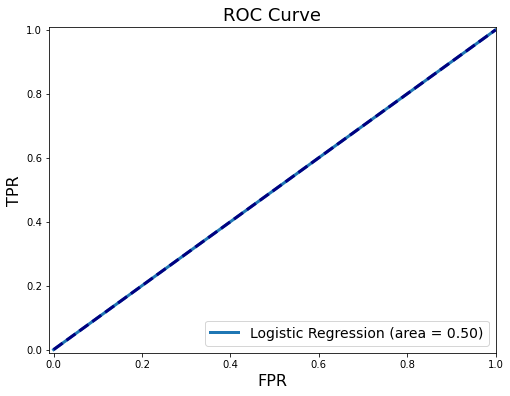

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y1_test_enc, y1_logreg_label)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr, tpr, lw=3, label='Logistic Regression (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.legend(loc='lower right', fontsize=14)
plt.show()

### cross-validation choosing c

In [59]:
from sklearn.metrics import confusion_matrix

def tpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tpr = cm.ravel()[3] / (cm.ravel()[2] + cm.ravel()[3])
    return tpr

def fpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fpr = cm.ravel()[1] / (cm.ravel()[0] + cm.ravel()[1])
    return fpr

In [60]:
from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import 
from sklearn.metrics import make_scorer

grid_values = { 'C': [10000,100,10,1,0.1,0.01],
                'max_iter': [50000000],
                'solver': ['saga'],
                'penalty': ['l2']
}

logreg = linear_model.LogisticRegression()
logreg_cv = GridSearchCV(logreg, param_grid=grid_values, 
                         scoring={'tpr':make_scorer(tpr), 'fpr':make_scorer(fpr,greater_is_better=False)},cv=5, refit=False)
logreg_cv.fit(X1_train_enc, y1_train_enc)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using r

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [10000, 100, 10, 1, 0.1, 0.01],
                         'max_iter': [50000000], 'penalty': ['l2'],
                         'solver': ['saga']},
             refit=False,
             scoring={'fpr': make_scorer(fpr, greater_is_better=False),
                      'tpr': make_scorer(tpr)})

In [65]:
fpr_lr = logreg_cv.cv_results_['mean_test_fpr']
tpr_lr = logreg_cv.cv_results_['mean_test_tpr']
c = logreg_cv.cv_results_['param_C'].data

pd.DataFrame({'C': c, 'TPR':tpr_lr, 'FPR':fpr_lr})

,C,TPR,FPR
0,10000,0.0,0.0
1,100,0.0,0.0
2,10,0.0,0.0
3,1,0.0,0.0
4,0.1,0.0,0.0
5,0.01,0.0,0.0


## CART 

#### max_depth=30

In [64]:
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
import time

def tpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tpr = cm.ravel()[3] / (cm.ravel()[2] + cm.ravel()[3])

    return tpr

def fpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fpr = cm.ravel()[1] / (cm.ravel()[0] + cm.ravel()[1])
    
    return fpr

grid_values = {'ccp_alpha': np.linspace(0, 0.1, 201),
               'min_samples_leaf': [5],
               'min_samples_split': [20],
               'max_depth': [30],
#                'class_weight' : [{0: 1, 1: 20}],
               'random_state': [88]} 

tic = time.time()

dtc2 = DecisionTreeClassifier()
dtc_cv2_logloss = GridSearchCV(dtc2, param_grid = grid_values,
                               scoring={'tpr':make_scorer(tpr), 'fpr':make_scorer(fpr,greater_is_better=False)},
                               cv=5, verbose=2, refit=False) 
dtc_cv2_logloss.fit(X1_train_enc, y1_train_enc)

toc = time.time()
print('time:', round(toc-tic, 2),'s')

Fitting 5 folds for each of 201 candidates, totalling 1005 fits
[CV] END ccp_alpha=0.0, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0005, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0005, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.0005, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s

[CV] END ccp_alpha=0.006500000000000001, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.8s
[CV] END ccp_alpha=0.006500000000000001, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.007, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.007, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.5s
[CV] END ccp_alpha=0.007, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.007, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.007, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0075, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.0075

[CV] END ccp_alpha=0.0135, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.0135, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0135, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0135, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.014, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.014, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.014, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.014, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.014, max_depth=30, min_samples_

[CV] END ccp_alpha=0.0205, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.0205, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.0205, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0205, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0205, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.021, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.021, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.021, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.021, max_depth=30, min_samples

[CV] END ccp_alpha=0.027, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.027, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0275, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0275, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.0275, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0275, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0275, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.028, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.028, max_depth=30, min_samples

[CV] END ccp_alpha=0.034, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.034, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.034, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0345, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.0345, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.0345, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.0345, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0345, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.035, max_depth=30, min_samples

[CV] END ccp_alpha=0.041, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.041, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.041, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.041, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.041, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0415, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.0415, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.0415, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0415, max_depth=30, min_samples_

[CV] END ccp_alpha=0.0475, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.0475, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.048, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.048, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.048, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.048, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.048, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0485, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0485, max_depth=30, min_samples_

[CV] END ccp_alpha=0.0545, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.0545, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0545, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0545, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.055, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.055, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.055, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.055, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.055, max_depth=30, min_samples_

[CV] END ccp_alpha=0.061, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0615, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.0615, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.0615, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0615, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0615, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.062, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.062, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.062, max_depth=30, min_samples

[CV] END ccp_alpha=0.068, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0685, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0685, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.0685, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0685, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0685, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.069, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.069, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.069, max_depth=30, min_samples

[CV] END ccp_alpha=0.075, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.075, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.075, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.075, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0755, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.0755, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.0755, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0755, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0755, max_depth=30, min_samples

[CV] END ccp_alpha=0.082, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.082, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.082, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.082, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0825, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0825, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.0825, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0825, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0825, max_depth=30, min_samples

[CV] END ccp_alpha=0.0885, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0885, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.089, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.089, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.089, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.089, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.089, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0895, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.0895, max_depth=30, min_samples_

[CV] END ccp_alpha=0.0955, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0955, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.096, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.096, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.6s
[CV] END ccp_alpha=0.096, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.096, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.096, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0965, max_depth=30, min_samples_leaf=5, min_samples_split=20, random_state=88; total time=   0.7s
[CV] END ccp_alpha=0.0965, max_depth=30, min_samples_

In [73]:
tpr_cart = dtc_cv2_logloss.cv_results_['mean_test_tpr']# what sklearn calls mean_test_score is the holdout set, i.e. the validation set.
fpr_cart = dtc_cv2_logloss.cv_results_['mean_test_fpr']
ccp = dtc_cv2_logloss.cv_results_['param_ccp_alpha'].data

pd.DataFrame({'ccp alpha' : ccp, 'TPR': tpr_cart, 'FPR':fpr_cart}).head(30)

,ccp alpha,TPR,FPR
0,0.0,0.528768,-0.018182
1,0.0005,0.485442,-0.001731
2,0.001,0.486403,-0.003050
3,0.0015,0.493905,-0.004170
4,0.002,0.493905,-0.004170
5,0.0025,0.480846,-0.003511
6,0.003,0.477215,-0.003066
7,0.0035,0.477215,-0.003066
8,0.004,0.477215,-0.003066
9,0.0045,0.477215,-0.003066


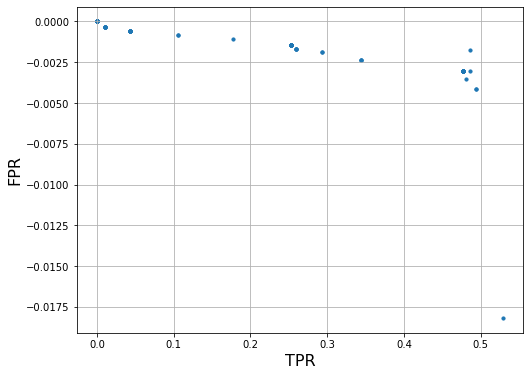

In [72]:
plt.figure(figsize=(8, 6))
plt.xlabel('TPR', fontsize=16)
plt.ylabel('FPR', fontsize=16)
plt.scatter(tpr_cart, fpr_cart, s=10)
# plt.plot(ccp, fpr_cart, linewidth=3)
plt.grid(True, which='both')
plt.show()

### cart1 with ccp_alpha=0.01

In [46]:
dtc1 = DecisionTreeClassifier(ccp_alpha=0.01, min_samples_leaf=5, min_samples_split=20, max_depth=30, random_state=88)
dtc1.fit(X1_train_enc, y1_train_enc)
y1_cart1_label = dtc1.predict(X1_test_enc)

In [47]:
def tpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tpr = cm.ravel()[3] / (cm.ravel()[2] + cm.ravel()[3])
    
    return tpr

def fpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fpr = cm.ravel()[1] / (cm.ravel()[0] + cm.ravel()[1])
    
    return fpr

In [48]:
tpr_dtc = tpr(y1_test_enc, y1_cart1_label)
print('tpr for cart is: ', tpr_dtc)
fpr_dtc = fpr(y1_test_enc, y1_cart1_label)
print('fpr for cart is: ', fpr_dtc)

tpr for cart is:  0.6414708886618999
fpr for cart is:  0.003288271830471319


### Random Forest 


#### CV of Random Forest parameters

In [79]:
X1_test_enc.shape

(23854, 98)

In [ ]:
# find suitable parameters
# other parameters are given in 242 lab
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import time

def tpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tpr = cm.ravel()[3] / (cm.ravel()[2] + cm.ravel()[3])
    
    return tpr

def fpr(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fpr = cm.ravel()[1] / (cm.ravel()[0] + cm.ravel()[1])
    
    return fpr

grid_values = {'max_features': np.linspace(1,98,98, dtype='int32'),
               'min_samples_leaf': [5],
               'max_depth':[30],
               'n_estimators': [500],
               'random_state': [88]} 

tic = time.time()

rf2 = RandomForestClassifier() 
rf_cv = GridSearchCV(rf2, param_grid=grid_values, 
                     scoring={'tpr':make_scorer(tpr), 'fpr':make_scorer(fpr,greater_is_better=False)}, 
                     cv=5, verbose=2, refit=False)
rf_cv.fit(X1_train_enc, y1_train_enc)

toc = time.time()

print('time:', round(toc-tic, 2),'s')

Fitting 5 folds for each of 98 candidates, totalling 490 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   6.1s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   6.5s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   6.5s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   6.2s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=1, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   6.2s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   9.7s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   9.7s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   9.7s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  10.0s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=2, min_samples_leaf=5, n_estimators=500, random_state=88; total time=   9.3s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=3, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  12.0s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=3, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  12.2s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=3, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  15.0s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=3, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  12.1s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=3, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  15.1s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=4, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  18.0s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=4, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  18.3s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=4, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  18.5s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=4, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  16.0s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=4, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  18.9s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=5, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  20.7s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=5, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  21.6s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=5, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  21.6s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=5, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  21.9s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=5, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  22.5s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=6, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  23.9s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=6, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  24.5s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=6, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  25.0s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=6, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  24.8s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=6, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  25.2s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=7, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  25.8s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=7, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  27.1s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=7, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  27.3s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=7, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  27.9s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=7, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  28.5s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=8, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  27.8s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=8, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  28.8s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=8, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  30.1s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=8, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  30.2s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=8, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  30.5s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=9, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  29.6s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=9, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  31.0s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=9, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  32.2s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=9, min_samples_leaf=5, n_estimators=500, random_state=88; total time= 2.8min


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=9, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  30.2s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=10, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  31.7s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=10, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  33.2s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=10, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  34.9s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=10, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  34.6s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=10, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  34.8s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=11, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  33.5s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=11, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  35.3s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=11, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  36.6s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=11, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  36.6s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=11, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  37.3s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=12, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  35.2s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=12, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  36.7s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=12, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  38.7s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=12, min_samples_leaf=5, n_estimators=500, random_state=88; total time= 4.7min


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=12, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  37.3s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=13, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  37.2s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=13, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  38.3s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=13, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  40.9s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=13, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  41.1s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=13, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  41.9s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=14, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  38.7s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=14, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  40.1s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=14, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  42.9s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=14, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  43.3s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=14, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  44.4s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=15, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  41.2s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=15, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  42.7s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=15, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  45.2s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=15, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  45.0s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=15, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  45.6s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=16, min_samples_leaf=5, n_estimators=500, random_state=88; total time=  42.4s


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=30, max_features=16, min_samples_leaf=5, n_estimators=500, random_state=88; total time= 5.8min


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:593: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


#### Feature Importance for Random Forest

In [ ]:
# importance score 
importance_score = pd.DataFrame({'Feature' : X1_train_enc.columns, 
              'Importance score': 100*rf_cv.best_estimator_.feature_importances_}).round(1)

In [ ]:
# top 50 importance score
top50_is = importance_score.sort_values('Importance score',ascending=False).head(50)
top50_is

### Visualization

In [ ]:
# prepare for visualization
ad_imp2clk_Vis = ad_imp2clk.copy()

#### distribution of `Paying Price` based on `has click`

In [ ]:
# mapping the label name 
has_click = {0 : 'not click', 1 :'click'}

In [ ]:
ad_imp2clk_Vis['has click'] = ad_imp2clk_Vis['has click'].map(has_click)

In [ ]:
ad_imp2clk_Vis['has click'].head()

In [ ]:
import seaborn as sns
sns.set_theme(style='whitegrid')
ax = sns.boxplot(x='has click', y='Paying Price', data=ad_imp2clk_Vis)

#### user profile `11278` based on `has click`

In [ ]:
ad_imp2clk_Vis.groupby('has click').sum()['11278']

In [ ]:
ad_imp_NoClk = ad_imp2clk[ad_imp2clk['has click'] == 0]

In [ ]:
# click
ad_clk['11278'].value_counts()

In [ ]:
# not click
ad_imp_NoClk['11278'].value_counts()

In [ ]:
# 11278: In-market/clothing、shoes&bags
from IPython.display import Image
Image(filename='/Users/jzw/Downloads/0 CAPSTONE/ipinyou.contest.dataset/data_exploration/11278.png') 

#### `Paying price` and  `has click`

In [ ]:
fig, ax = plt.subplots()
groups = ad_imp2clk.groupby('Region ID_clicks')
ax.margins(0.05)
for name, group in groups:
    ax.plot(group['Paying Price'], group['has click'], marker='o', linestyle='', ms=12, label=name)
# ax.legend(loc='best')
plt.ylim([-0.01, 1.04])
plt.xlabel('Paying Price')
plt.ylabel('click label')

#### `Timestamp` and `has click` 

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(ad_imp2clk['Timestamp_imp'], ad_imp2clk['has click'])
plt.ylim([-0.01, 1.00])
plt.xlabel('Timestamp')
plt.ylabel('click label')

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

x = [4,8,12,16,1,4,9,16]
y = [1,4,9,16,4,8,12,3]
label = [0,1,2,3,0,1,2,3]
colors = ['red','green','blue','purple']

fig = plt.figure(figsize=(8,8))
plt.scatter(x, y, c=label, cmap=matplotlib.colors.ListedColormap(colors))

cb = plt.colorbar()
loc = np.arange(0,max(label),max(label)/float(len(colors)))
cb.set_ticks(loc)
cb.set_ticklabels(colors)
